# K-Nearest Neighbours

K-Nearest Neigbours (KNN) can be used for both classification and regression problems. However, it is more widely used in classification problems in the ML industry. K-nearest neighbours is a simple algorithm that stores all available cases and classifies new cases by a majority vote of its _K_ neighbours. The case assigned to the class is the most common amongst its K-nearest neighbours, measured by a distance function. 

At a top level, the KNN algorithm works in the following way:

1. Choose the number of _K_ neighbours and a distance metric
2. Find the _K_ nearest neighbours of the sample that we want to classify
3. Assign the class label by majority vote

The distance function can be Euclidean, Manhattan, Minkowski, or Hamming distance. The first three functions are used for continuous functions and Hamming is used for categorical variables. If _K_ = 1, then the case is simply assigned to the class of its nearest neighbor. 

At times, choosing _K_ turns out to be a challenge while performing KNN modeling. It is key to finding a good balance between under and over fitting. The Minlowski distance function is a generalised version of the Euclidean and Manhattan distances, and becomes the Euclidean in [SciKit-Learn](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) if we set the Power Parameter p=2 or Manhattan if we set p=1.

KNN is an example of a _lazy learner_. It is called lazy because it doesnt learn to discriminate the training data through a function. It is an _instance beased learning_ model that memorises the training dataset. As new training data is collected the classifier imediately adapts to it. However the computational complexity for classifiying new samples grows linearly with the number of samples in the training set. As no training step is involved we cant discard training samples and so storage space can be a challenge!

KNN can easily be mapped to our real lives. If you want to learn about a person about whom you have no information, you might like to find out about their close friends and the circles they move in to gain access to their information!

Things to consider before selecting KNN:
* KNN is computationally expensive.
* Variables should be normalized, or else higher-range variables can bias it.
* Work on the pre-processing stage more before going for KNN, like outlier/noise removal.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from sklearn.neighbors import KNeighborsClassifier
import scikit_utilities as ut

### Data

In [3]:
X_train_std, y_train, X_test_std, y_test, X_combined_std, y_combined, X_train, X_test = ut.get_iris_data()

[0 1 2]
Training Data set is 105 values long


### Model

In [4]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_std, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

### Evaluate the Model

We can use the model predict_proba method to predict the probability of data. Lets take the first 2 X_test_std data row and make a predictions on them:

In [5]:
X_test_std[0:2,:]

array([[ 0.70793846,  1.50872803],
       [ 0.09545238, -0.29145882]])

In [6]:
knn.predict_proba(X_test_std[0:2,:])

array([[ 0.,  0.,  1.],
       [ 0.,  1.,  0.]])

This says that the model predicts the first X data row belongs to class 0 (iris- setosa) with a P=0, class 1 (iris-versicolor) with a probability of P=08 and class 2 (iris-virginica) with a probability of 1.

In [7]:
# predict the response
pred = knn.predict(X_test_std)
pred

array([2, 1, 0, 2, 0, 2, 0, 1, 1, 1, 2, 1, 1, 1, 1, 0, 1, 1, 0, 0, 2, 1, 0,
       0, 2, 0, 0, 1, 1, 0, 2, 1, 0, 2, 2, 1, 0, 1, 1, 1, 2, 0, 2, 0, 0])

#### Estimating accuracy with a score
We can score how accurate the model is by using the KNN ```score``` method. This is done by supplying the method with the __standardised X test data and the y test__ data sets. This assesses how many of the test data points the model predicted correctly and indicates accuracy.

$$\textsf{fraction of correct predictions:} \frac{\textsf{correct predictions}}{\textsf{total number of data points}} $$

In [8]:
# evaluate accuracy
print("The model has an accuracy of %.1f%%" % (knn.score(X_test_std, y_test)*100))

The model has an accuracy of 100.0%


### Plot

In [9]:
# Will allow us to embed images in the notebook
%matplotlib inline
%pylab inline
#Sets the figure size
pylab.rcParams['figure.figsize'] = (10, 10)

Populating the interactive namespace from numpy and matplotlib


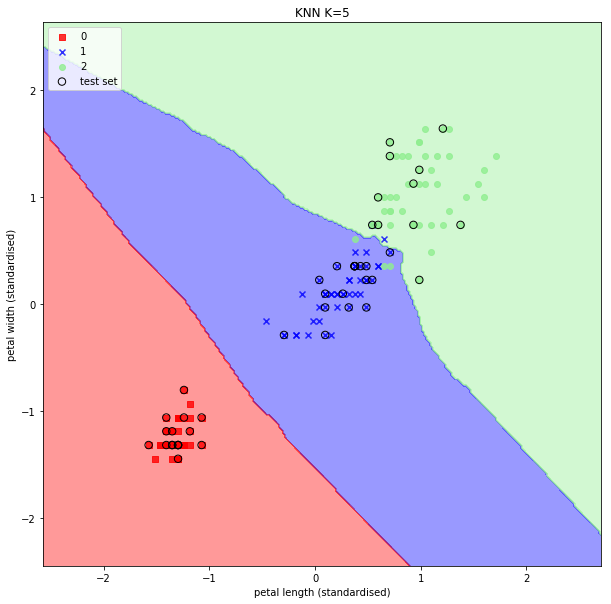

In [10]:
plt=ut.plot_decision_regions(X_combined_std, y_combined, classifier=knn, test_idx=range(105,150))
plt,title('KNN K=5')
plt.xlabel('petal length (standardised)')
plt.ylabel('petal width (standardised)')
plt.legend(loc='upper left')

### Choosing K

Choosing the best value of _K_ is important for the performance of KNN. The simplest is to set _K_=1 to set the data point to the same set as its nearest neighbours, known as the 1-nearest neighbour classifier. However this is rarely the best choice. If _K_ is too low we tend to overfit the data, forcing the classifier to be 'blind' to the overall distrubtion. A small _K_ provides a flexible fit - decision boundaries will appear jagged.  Higher values of _K_ provide a smoothing effect and is more resilient to outliers but take it too far and the KNN will fail to capture local structure data and become inaccurate. 

Choosing the optimum _K_ depends on the nature of the dataset, its structure and how noisy it is. For highly structured data with little noise (such as handwriting and speech recognition) lower values of _K_ work best. Often an odd number is choosen to avoid ties when assigning the class label. 

Lets change _K_ and see what affect it has on the error and the shape of our decision boundaries. 
To assess this we can hold a  We can do this using k-fold cross validation. In this technique:

1. 1/k of the data is removed from the data as a hold out set
2. the model is trained on the remaining data 
3. score the model on the holdout set
4. restore the initial holdoutset, and choose the next 1/k datapoints (this should exclude any used in the previous holdout)
5. Repeat 2 and 3
6. Repeat until all data has been used in a holdout portion.
7. Average/combine the model assessment metrics

This helps to remove uncertainty from variability in a small holdout set.

Cross-validation can be used to estimate the test error associated with a learning method in order to evaluate its performance, or to select the appropriate level of flexibility. Scikit-learn comes in handy with its cross_val_score() method. We specifiy that we are performing 10 folds with the cv=10 parameter and that our scoring metric should be accuracy since we are in a classification setting.

In [11]:
# creating odd list of K for KNN
neighbors = list(range(1,52,2))

#Lets keep a list of the model performance using Cross validation Scoring
cv_scores = []

from sklearn.model_selection import cross_val_score

# perform 10-fold cross validation 
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())

Lets investigate the performance of each _K_:

The optimal number of neighbors is 37


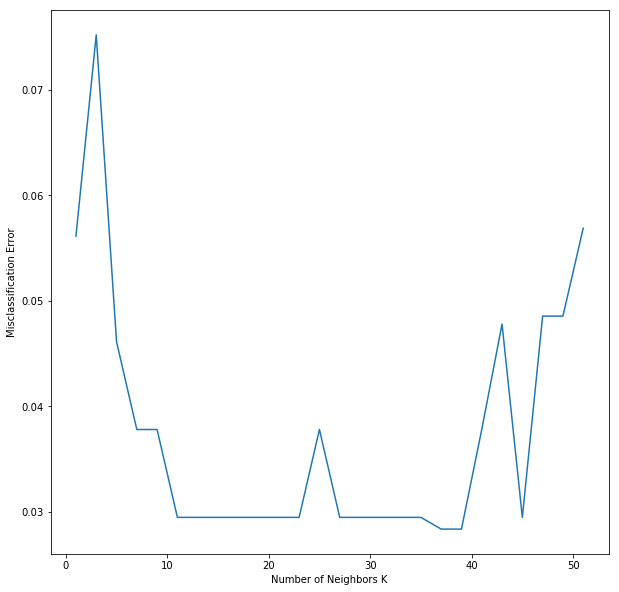

In [12]:
# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors[MSE.index(min(MSE))]
print("The optimal number of neighbors is %d" % optimal_k)

# plot misclassification error vs k
plt.plot(neighbors, MSE)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')

We see that invcreasing the value of _K_ initially reduces the error, but as _K_ increases beyond 40 it smooths out the data too much and starts to misclassifiy the data. A K value around 10 to 15 is a resonable choice.

lets see how these models appear:

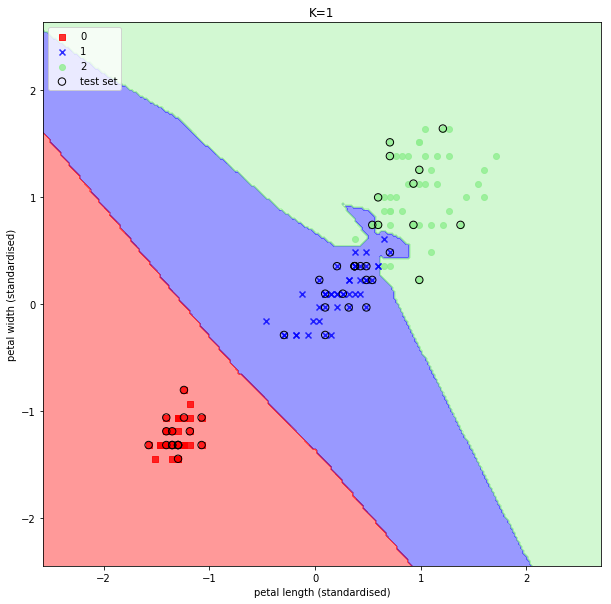

In [13]:
knn1 = KNeighborsClassifier(n_neighbors=1)
knn1.fit(X_combined_std, y_combined)
plt=ut.plot_decision_regions(X_combined_std, y_combined, classifier=knn1, test_idx=range(105,150))
plt.title('K=1')
plt.xlabel('petal length (standardised)')
plt.ylabel('petal width (standardised)')
plt.legend(loc='upper left')
plt.show()

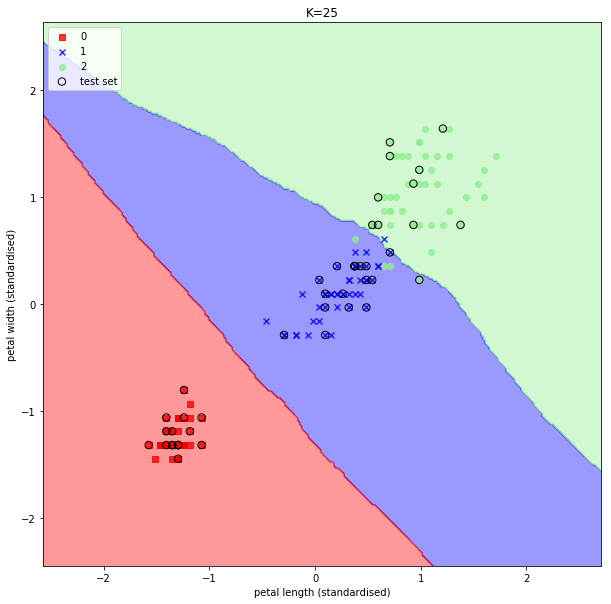

In [14]:
knn25 = KNeighborsClassifier(n_neighbors=25)
knn25.fit(X_combined_std, y_combined)
plt=ut.plot_decision_regions(X_combined_std, y_combined, classifier=knn25, test_idx=range(105,150))
plt.title('K=25')
plt.xlabel('petal length (standardised)')
plt.ylabel('petal width (standardised)')
plt.legend(loc='upper left')
plt.show()

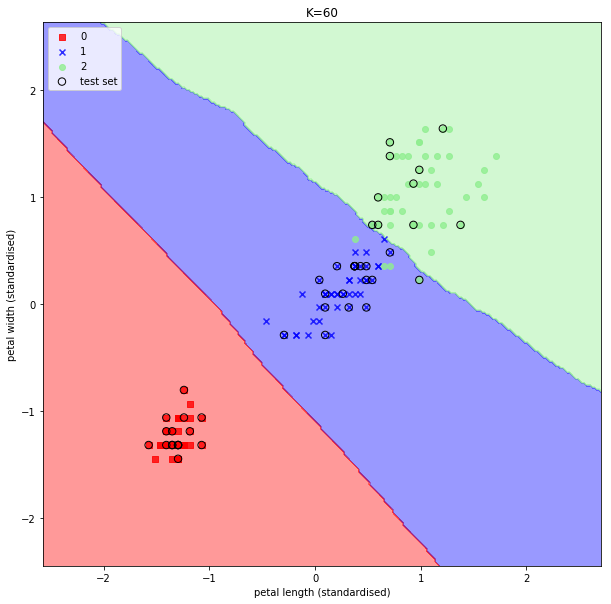

In [15]:
knn60 = KNeighborsClassifier(n_neighbors=60)
knn60.fit(X_combined_std, y_combined)
plt=ut.plot_decision_regions(X_combined_std, y_combined, classifier=knn60, test_idx=range(105,150))
plt.title('K=60')
plt.xlabel('petal length (standardised)')
plt.ylabel('petal width (standardised)')
plt.legend(loc='upper left')
plt.show()

### The Curse of Dimensionality

As the dimension of a fixed size data set increases the feature space becomes increasingly sparse and the closest neighbour can be too far away to yield a good estimate. Dimensionality reduction becomes important for models like KNN.